# Load Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
if 'google.colab' in str(get_ipython()):
    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/dataset/DSA4212/assignment_2/

Mounted at /content/drive
/content/drive/MyDrive/dataset/DSA4212/assignment_2


In [3]:
pip install annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.0/648.0 KB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.1-cp39-cp39-linux_x86_64.whl size=582305 sha256=f1e7f8626d5dc33d71fee0f12d77f642f295d38c65768611d3cbe3851efc491b
  Stored in directory: /root/.cache/pip/wheels/5b/7d/31/9a9a4993d085bc85bee21946bce94cd5906ce99730f5467e57
Successfully built annoy


In [4]:
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
import re
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import xgboost
from xgboost import XGBRegressor

In [5]:
from torch import nn
import torch
from torch.nn  import functional as F
import torch.optim as  optim 
if torch.cuda.is_available():  
  dev = "cuda:0" 
  print("gpu up")
else:  
  dev = "cpu"  
device = torch.device(dev)

gpu up


In [6]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [7]:
anime = pd.read_csv("assignment_2_anime.csv")
train = pd.read_csv("assignment_2_ratings_train.csv")
test = pd.read_csv("assignment_2_ratings_test.csv")

# User Mean + Movie Mean (lr 1.512, XGB 1.494)

In [ ]:
avg_user_train_rating = train.groupby("user_id", as_index = False).agg({"rating": [onp.mean]})

In [ ]:
def get_user_movie_mean_df(df):
    df = df.merge(anime, how = "left", on = "anime_id", suffixes = ('','_predicted'))
    df.drop(['name', 'genre', 'type', 'episodes', 'members'], axis = 1, inplace = True)
    df = df.merge(avg_user_train_rating, how = "left", on = "user_id", suffixes = ('','_predicted'))
    df = df.rename(columns = {"rating_predicted": "movie_mean", ("rating", "mean"): "user_mean"})
    df["movie_mean"] = df["movie_mean"].fillna(6.474)
    df["user_mean"] = df["user_mean"].fillna(8.216)
    return df

In [ ]:
train1 = get_user_movie_mean_df(train)
test1 = get_user_movie_mean_df(test)

<ipython-input-11-ce6b2b3bcd8f>:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df = df.merge(avg_user_train_rating, how = "left", on = "user_id", suffixes = ('','_predicted'))
<ipython-input-11-ce6b2b3bcd8f>:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.merge(avg_user_train_rating, how = "left", on = "user_id", suffixes = ('','_predicted'))
<ipython-input-11-ce6b2b3bcd8f>:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df = df.merge(avg_user_train_rating, how = "left", on = "user_id", suffixes = ('','_predicted'))
<ipython-input-11-ce6b2b3bcd8f>:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.merge(avg_user_train_rating, how = "left", on = "

In [ ]:
train1

,user_id,anime_id,rating,movie_mean,user_mean
0,20170,10794,6,7.12,6.199052
1,24592,21995,5,7.89,7.333333
2,18358,7054,10,8.26,9.991935
3,59267,488,7,7.77,7.574468
4,69313,30544,4,7.14,7.992308
...,...,...,...,...,...
4436063,32872,15061,7,7.69,7.785992
4436064,66206,20507,8,8.17,7.413043
4436065,46386,834,7,7.05,7.598039
4436066,10497,9159,7,7.21,7.712912


In [ ]:
test1

,user_id,anime_id,rating,movie_mean,user_mean
0,44017,13161,4,7.25,7.691011
1,14307,14993,7,6.66,7.419919
2,55155,268,9,8.05,9.015152
3,63515,2889,9,7.60,8.614458
4,54059,2581,7,8.24,7.976190
...,...,...,...,...,...
1901168,56619,31483,10,7.77,7.960073
1901169,24755,1210,8,8.40,7.634146
1901170,17346,15225,6,7.46,6.373737
1901171,28874,5041,8,7.29,8.111111


In [ ]:
lr = LinearRegression()
lr.fit(train1[["movie_mean", "user_mean"]], train1["rating"])

LinearRegression()

In [ ]:
lr.coef_

array([0.87414221, 0.9431568 ])

In [ ]:
lr.intercept_

-6.265070301326998

In [ ]:
predicted_test_1_lr = lr.predict(test1[["movie_mean", "user_mean"]])

In [ ]:
mean_squared_error(test["rating"], predicted_test_1_lr)

1.5116066528190755

In [ ]:
xgb_model = XGBRegressor()

In [ ]:
xgb_model.fit(train1[["movie_mean", "user_mean"]], train1["rating"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
predicted_test_1_xgb = xgb_model.predict(test1[["movie_mean", "user_mean"]])

In [ ]:
mean_squared_error(test["rating"], predicted_test_1_xgb)

1.493804838221738

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

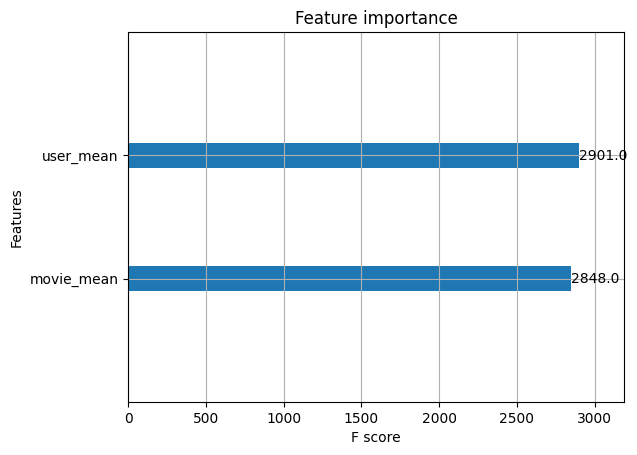

In [ ]:
xgboost.plot_importance(xgb_model)

# User Mean + Movie Mean + User Total Rated + Movie Total Rated + User & Film Min Max Rating + Movie Data without Name (lr 1.497, XGB 1.46)

In [10]:
anime1 = anime.copy()

In [11]:
anime.genre = anime1.genre.fillna("")

In [12]:
anime1.genre = anime1.genre.apply(lambda text: str(text).split(", "))

In [13]:
anime1.drop(["name"], axis = 1, inplace = True)

In [14]:
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, stop_words=[''])
X = cv.fit_transform(anime1.genre)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [15]:
cv.get_feature_names_out()

array(['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons',
       'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai',
       'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts',
       'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police',
       'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi',
       'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai',
       'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural',
       'Thriller', 'Vampire', 'Yaoi', 'Yuri', 'nan'], dtype=object)

In [16]:
anime_genres_df = pd.DataFrame(X.toarray(), columns = cv.get_feature_names_out())

In [17]:
anime1.drop(["genre"], inplace = True, axis = 1)

In [18]:
mean_episodes = anime1[anime1.episodes != "Unknown"].episodes.astype(int).mean()

In [19]:
anime1["episodes"] = anime1["episodes"].apply(lambda x: int(x) if x != "Unknown" else mean_episodes)

In [20]:
anime1 = pd.get_dummies(anime1)

In [21]:
anime1.rating = anime1.rating.fillna(6.474)

In [22]:
anime1

,anime_id,episodes,rating,members,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV
0,32281,1.0,9.37,200630,1,0,0,0,0,0
1,5114,64.0,9.26,793665,0,0,0,0,0,1
2,28977,51.0,9.25,114262,0,0,0,0,0,1
3,9253,24.0,9.17,673572,0,0,0,0,0,1
4,9969,51.0,9.16,151266,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
12289,9316,1.0,4.15,211,0,0,0,1,0,0
12290,5543,1.0,4.28,183,0,0,0,1,0,0
12291,5621,4.0,4.88,219,0,0,0,1,0,0
12292,6133,1.0,4.98,175,0,0,0,1,0,0


In [23]:
anime1 = pd.concat([anime1, anime_genres_df], axis = 1)

In [24]:
anime1

,anime_id,episodes,rating,members,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,nan
0,32281,1.0,9.37,200630,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,5114,64.0,9.26,793665,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,28977,51.0,9.25,114262,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,9253,24.0,9.17,673572,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,9969,51.0,9.16,151266,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12289,9316,1.0,4.15,211,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12290,5543,1.0,4.28,183,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12291,5621,4.0,4.88,219,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12292,6133,1.0,4.98,175,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
user_train_agg_data = train.groupby("user_id", as_index = False).agg({"rating": [onp.mean, 'count', 'min', 'max']})

In [26]:
user_train_agg_data

user_id     rating              
                    mean count min max
0           1  10.000000     3  10  10
1           3   7.406250    64   3  10
2           5   4.452830   318   1  10
3           7   7.337553   237   4  10
4           8   7.666667     6   5   9
...       ...        ...   ...  ..  ..
68416   73512   8.555556     9   5  10
68417   73513   7.583333    24   5  10
68418   73514  10.000000     1  10  10
68419   73515   8.528571   140   5  10
68420   73516   9.000000     2   9   9

[68421 rows x 5 columns]

In [27]:
movie_train_agg_data = train.groupby("anime_id", as_index = False).agg({"rating": ['count', 'min', 'max']})

In [28]:
movie_train_agg_data

anime_id rating        
               count min max
0           1   9314   1  10
1           5   4058   2  10
2           6   6629   1  10
3           7   1488   1  10
4           8    224   3  10
...       ...    ...  ..  ..
9627    34324      6   5   8
9628    34325     13   4   8
9629    34349      3   6   8
9630    34367      3   4   6
9631    34475      2   5   9

[9632 rows x 4 columns]

In [29]:
def get_user_movie_mean_df(df):
    df = df.merge(anime1, how = "left", on = "anime_id", suffixes = ('','_predicted'))
    # df.drop(['name', 'genre', 'type', 'episodes', 'members'], axis = 1, inplace = True)
    df = df.merge(user_train_agg_data, how = "left", on = "user_id", suffixes = ('','_predicted'))
    df = df.rename(columns = {"rating_predicted": "movie_mean_rating", ("rating", "mean"): "user_mean_rating", ("rating", "count"): "user_count_ratings"\
                              , ("rating", "min"): "user_min_rating", ("rating", "max"): "user_max_rating"})
    df["movie_mean_rating"] = df["movie_mean_rating"].fillna(6.474)
    df["user_mean_rating"] = df["user_mean_rating"].fillna(8.216)
    df["user_min_rating"] = df["user_min_rating"].fillna(user_train_agg_data.mean().rating["min"])
    df["user_max_rating"] = df["user_max_rating"].fillna(user_train_agg_data.mean().rating["max"])
    df = df.merge(movie_train_agg_data, how = "left", on = "anime_id", suffixes = ('','_predicted'))
    df = df.rename(columns = {("rating", "count"): "movie_count_ratings", ("rating", "min"): "movie_min_rating", ("rating", "max"): "movie_max_rating"})
    df["movie_min_rating"] = df["movie_min_rating"].fillna(movie_train_agg_data.mean().rating["min"])
    df["movie_max_rating"] = df["movie_max_rating"].fillna(movie_train_agg_data.mean().rating["max"])
    return df

In [30]:
train1 = get_user_movie_mean_df(train)
test1 = get_user_movie_mean_df(test)
test1.user_count_ratings = test1.user_count_ratings.fillna(0)
test1.movie_count_ratings = test1.movie_count_ratings.fillna(0)

<ipython-input-29-7aacb82e29d5>:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df = df.merge(user_train_agg_data, how = "left", on = "user_id", suffixes = ('','_predicted'))
<ipython-input-29-7aacb82e29d5>:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.merge(user_train_agg_data, how = "left", on = "user_id", suffixes = ('','_predicted'))
<ipython-input-29-7aacb82e29d5>:11: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df = df.merge(movie_train_agg_data, how = "left", on = "anime_id", suffixes = ('','_predicted'))
<ipython-input-29-7aacb82e29d5>:11: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.merge(movie_train_agg_data, how = "left", on = "ani

In [31]:
test1[test1.isna().any(axis=1)]

,user_id,anime_id,rating,episodes,movie_mean_rating,members,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,nan,user_mean_rating,user_count_ratings,user_min_rating,user_max_rating,movie_count_ratings,movie_min_rating,movie_max_rating
427667,34240,30913,9,NaN,6.474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.721311,61.0,4.0,10.0,0.0,2.844996,8.991902
532564,37442,30913,9,NaN,6.474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.551724,29.0,6.0,10.0,0.0,2.844996,8.991902


In [32]:
test1 = test1.fillna(train1.mean())

In [33]:
test1[test1.isna().any(axis=1)]

,user_id,anime_id,rating,episodes,movie_mean_rating,members,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,nan,user_mean_rating,user_count_ratings,user_min_rating,user_max_rating,movie_count_ratings,movie_min_rating,movie_max_rating


In [34]:
lr = LinearRegression()
lr.fit(train1.drop(["user_id", "anime_id", "rating"], axis = 1), train1["rating"])

LinearRegression()

In [35]:
lr.coef_

array([-5.57962293e-05,  9.06631099e-01,  4.55836777e-08, -1.39878184e+00,
       -1.22683562e+00, -1.35208262e+00, -1.40008716e+00, -1.43851292e+00,
       -1.39993736e+00, -7.44815306e-03, -1.17140004e-02, -5.65227300e-02,
       -1.14886071e-02,  1.80216500e-02, -4.67412288e-02,  2.88133984e-03,
       -3.47401008e-02, -2.88671020e-03,  1.83636747e-03, -4.63608030e-02,
        2.39568662e-02,  3.09853349e-02, -8.08225736e-03, -1.56509582e-02,
       -5.92384563e-02,  9.45087403e-03, -3.04220709e-02,  3.37028421e-03,
        2.24054801e-02,  2.35527678e-02,  1.28045248e-02,  2.83800125e-02,
       -2.55086826e-02,  5.79946589e-03, -7.74730794e-03, -6.28303386e-03,
       -1.95088967e-02,  1.97304737e-02,  4.46056744e-03, -1.01578458e-01,
        2.26854456e-02, -4.02157001e-02, -8.62849937e-02,  1.70295028e-02,
        5.26034777e-02, -3.15225464e-02, -1.37611427e-02, -9.22321227e-03,
        5.63056876e-02,  2.86523163e-03, -1.02357536e-01,  1.85512827e-02,
       -2.64177572e-01,  

In [36]:
predicted_test_1_lr = lr.predict(test1.drop(["user_id", "anime_id", "rating"], axis = 1))

In [37]:
mean_squared_error(test["rating"], predicted_test_1_lr)

1.4968387316562481

In [38]:
xgb_model = XGBRegressor()

In [39]:
xgb_model.fit(train1.drop(["user_id", "anime_id", "rating"], axis = 1), train1["rating"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [40]:
predicted_test_1_xgb = xgb_model.predict(test1.drop(["user_id", "anime_id", "rating"], axis = 1))

In [41]:
mean_squared_error(test["rating"], predicted_test_1_xgb)

1.4599668803617871

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

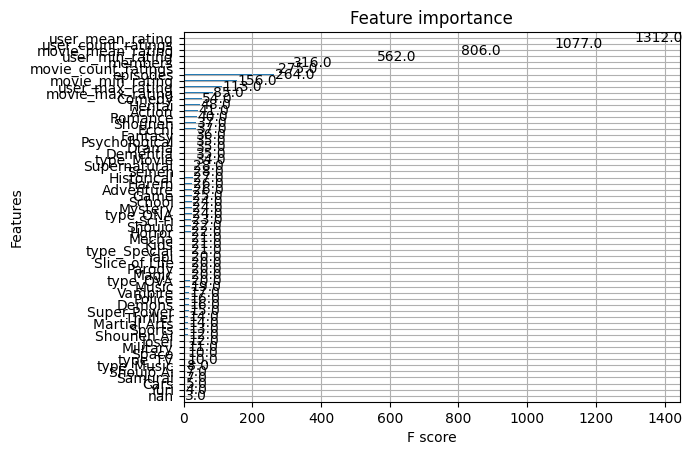

In [42]:
xgboost.plot_importance(xgb_model)

# User Mean + Movie Mean + User Total Rated + Movie Total Rated + User & Film Min Max Rating + Movie Data without Name (NN Embedding 100, lr 0.003, batch 100, size 4096, 1.43)

https://www.kaggle.com/code/nadergo/hybrid-anime-recommendations-with-pytorch

In [ ]:
anime1 = anime.copy()

In [ ]:
anime.genre = anime1.genre.fillna("")

In [ ]:
anime1.genre = anime1.genre.apply(lambda text: str(text).split(", "))

In [ ]:
anime1.drop(["name"], axis = 1, inplace = True)

In [ ]:
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, stop_words=[''])
X = cv.fit_transform(anime1.genre)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
cv.get_feature_names_out()

array(['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons',
       'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai',
       'Historical', 'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts',
       'Mecha', 'Military', 'Music', 'Mystery', 'Parody', 'Police',
       'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi',
       'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai',
       'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural',
       'Thriller', 'Vampire', 'Yaoi', 'Yuri', 'nan'], dtype=object)

In [ ]:
anime_genres_df = pd.DataFrame(X.toarray(), columns = cv.get_feature_names_out())

In [ ]:
anime1.drop(["genre"], inplace = True, axis = 1)

In [ ]:
mean_episodes = anime1[anime1.episodes != "Unknown"].episodes.astype(int).mean()

In [ ]:
anime1["episodes"] = anime1["episodes"].apply(lambda x: int(x) if x != "Unknown" else mean_episodes)

In [ ]:
anime1 = pd.get_dummies(anime1)

In [ ]:
anime1.rating = anime1.rating.fillna(6.474)

In [ ]:
anime1

,anime_id,episodes,rating,members,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV
0,32281,1.0,9.37,200630,1,0,0,0,0,0
1,5114,64.0,9.26,793665,0,0,0,0,0,1
2,28977,51.0,9.25,114262,0,0,0,0,0,1
3,9253,24.0,9.17,673572,0,0,0,0,0,1
4,9969,51.0,9.16,151266,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
12289,9316,1.0,4.15,211,0,0,0,1,0,0
12290,5543,1.0,4.28,183,0,0,0,1,0,0
12291,5621,4.0,4.88,219,0,0,0,1,0,0
12292,6133,1.0,4.98,175,0,0,0,1,0,0


In [ ]:
anime1 = pd.concat([anime1, anime_genres_df], axis = 1)

In [ ]:
anime1

,anime_id,episodes,rating,members,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,nan
0,32281,1.0,9.37,200630,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,5114,64.0,9.26,793665,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,28977,51.0,9.25,114262,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,9253,24.0,9.17,673572,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,9969,51.0,9.16,151266,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12289,9316,1.0,4.15,211,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12290,5543,1.0,4.28,183,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12291,5621,4.0,4.88,219,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12292,6133,1.0,4.98,175,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
user_train_agg_data = train.groupby("user_id", as_index = False).agg({"rating": [onp.mean, 'count', 'min', 'max']})

In [ ]:
user_train_agg_data

user_id     rating              
                    mean count min max
0           1  10.000000     3  10  10
1           3   7.406250    64   3  10
2           5   4.452830   318   1  10
3           7   7.337553   237   4  10
4           8   7.666667     6   5   9
...       ...        ...   ...  ..  ..
68416   73512   8.555556     9   5  10
68417   73513   7.583333    24   5  10
68418   73514  10.000000     1  10  10
68419   73515   8.528571   140   5  10
68420   73516   9.000000     2   9   9

[68421 rows x 5 columns]

In [ ]:
movie_train_agg_data = train.groupby("anime_id", as_index = False).agg({"rating": ['count', 'min', 'max']})

In [ ]:
movie_train_agg_data

anime_id rating        
               count min max
0           1   9314   1  10
1           5   4058   2  10
2           6   6629   1  10
3           7   1488   1  10
4           8    224   3  10
...       ...    ...  ..  ..
9627    34324      6   5   8
9628    34325     13   4   8
9629    34349      3   6   8
9630    34367      3   4   6
9631    34475      2   5   9

[9632 rows x 4 columns]

In [ ]:
def get_user_movie_mean_df(df):
    df = df.merge(anime1, how = "left", on = "anime_id", suffixes = ('','_predicted'))
    # df.drop(['name', 'genre', 'type', 'episodes', 'members'], axis = 1, inplace = True)
    df = df.merge(user_train_agg_data, how = "left", on = "user_id", suffixes = ('','_predicted'))
    df = df.rename(columns = {"rating_predicted": "movie_mean_rating", ("rating", "mean"): "user_mean_rating", ("rating", "count"): "user_count_ratings"\
                              , ("rating", "min"): "user_min_rating", ("rating", "max"): "user_max_rating"})
    df["movie_mean_rating"] = df["movie_mean_rating"].fillna(6.474)
    df["user_mean_rating"] = df["user_mean_rating"].fillna(8.216)
    df["user_min_rating"] = df["user_min_rating"].fillna(user_train_agg_data.mean().rating["min"])
    df["user_max_rating"] = df["user_max_rating"].fillna(user_train_agg_data.mean().rating["max"])
    df = df.merge(movie_train_agg_data, how = "left", on = "anime_id", suffixes = ('','_predicted'))
    df = df.rename(columns = {("rating", "count"): "movie_count_ratings", ("rating", "min"): "movie_min_rating", ("rating", "max"): "movie_max_rating"})
    df["movie_min_rating"] = df["movie_min_rating"].fillna(movie_train_agg_data.mean().rating["min"])
    df["movie_max_rating"] = df["movie_max_rating"].fillna(movie_train_agg_data.mean().rating["max"])
    return df

In [ ]:
train = train[["rating","user_id","anime_id"]]
test = test[["rating","user_id","anime_id"]]

In [ ]:
train1 = get_user_movie_mean_df(train)
test1 = get_user_movie_mean_df(test)
test1.user_count_ratings = test1.user_count_ratings.fillna(0)
test1.movie_count_ratings = test1.movie_count_ratings.fillna(0)

<ipython-input-29-7aacb82e29d5>:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df = df.merge(user_train_agg_data, how = "left", on = "user_id", suffixes = ('','_predicted'))
<ipython-input-29-7aacb82e29d5>:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.merge(user_train_agg_data, how = "left", on = "user_id", suffixes = ('','_predicted'))
<ipython-input-29-7aacb82e29d5>:11: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df = df.merge(movie_train_agg_data, how = "left", on = "anime_id", suffixes = ('','_predicted'))
<ipython-input-29-7aacb82e29d5>:11: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.merge(movie_train_agg_data, how = "left", on = "ani

In [ ]:
test1[test1.isna().any(axis=1)]

,rating,user_id,anime_id,episodes,movie_mean_rating,members,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,nan,user_mean_rating,user_count_ratings,user_min_rating,user_max_rating,movie_count_ratings,movie_min_rating,movie_max_rating
427667,9,34240,30913,NaN,6.474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.721311,61.0,4.0,10.0,0.0,2.844996,8.991902
532564,9,37442,30913,NaN,6.474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.551724,29.0,6.0,10.0,0.0,2.844996,8.991902


In [ ]:
test1 = test1.fillna(train1.mean())

In [ ]:
test1[test1.isna().any(axis=1)]

,rating,user_id,anime_id,episodes,movie_mean_rating,members,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,Hentai,Historical,Horror,Josei,Kids,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri,nan,user_mean_rating,user_count_ratings,user_min_rating,user_max_rating,movie_count_ratings,movie_min_rating,movie_max_rating


In [ ]:
train = train1.copy()
train1 = None

test = test1.copy()
test1 = None

In [ ]:
all_anime_ids = pd.concat([anime["anime_id"], test["anime_id"], train["anime_id"]], axis = 0).reset_index()

In [ ]:
all_anime_ids.drop(["index"], inplace = True, axis = 1)

In [ ]:
all_anime_ids["anime_id"].unique()

array([32281,  5114, 28977, ...,  6133, 26081, 30913])

In [ ]:
all_user_ids = pd.concat([test["user_id"], train["user_id"]], axis = 0).reset_index()

In [ ]:
all_user_ids.drop(["index"], inplace = True, axis = 1)

In [ ]:
all_user_ids["user_id"].unique()

array([44017, 14307, 55155, ..., 31859, 56730,  3516])

In [ ]:
membersEnc = MinMaxScaler()
avgRatingEnc = MinMaxScaler()
episodesEnc = MinMaxScaler()

animeEncoder = LabelEncoder()
userEncoder = LabelEncoder()

animeEncoder.fit(all_anime_ids["anime_id"].unique())
userEncoder.fit(all_user_ids["user_id"].unique())

"""
since the anime id and user ids are not consecutive numbers, we will have to label encode them for the embedding layer 
"""

anime["anime_id"] = animeEncoder.transform(anime["anime_id"]) #add test

train["anime_id"] = animeEncoder.transform(train["anime_id"])
train["user_id"] = userEncoder.transform(train["user_id"])
train["movie_mean_rating"] = avgRatingEnc.fit_transform(train["movie_mean_rating"].to_numpy().reshape(-1,1))[:,0]
train["members"] = membersEnc.fit_transform(train["members"].to_numpy().reshape(-1,1))[:,0]
train["episodes"] = episodesEnc.fit_transform(train["episodes"].to_numpy().reshape(-1,1))[:,0]

test["anime_id"] = animeEncoder.transform(test["anime_id"])
test["user_id"] = userEncoder.transform(test["user_id"])
test["movie_mean_rating"] = avgRatingEnc.transform(test["movie_mean_rating"].to_numpy().reshape(-1,1))[:,0]
test["members"] = membersEnc.transform(test["members"].to_numpy().reshape(-1,1))[:,0]
test["episodes"] = episodesEnc.fit_transform(test["episodes"].to_numpy().reshape(-1,1))[:,0]

In [ ]:
train.shape

(4436068, 63)

In [ ]:
"""
finally the neural network 

"""

class RecommendationNet(nn.Module):
    def __init__(self):
        super(RecommendationNet,self).__init__()
        self.users = nn.Embedding(73517,100) 
        self.animes = nn.Embedding(12294,100)
        self.linear1 = nn.Linear(100+100+60,128)
        self.linear2 = nn.Linear(128,32)
        self.linear3 = nn.Linear(32,1)
    def forward(self,x):
        user = x[:,0].long() # here am selecting the user and anime ids from the input 
        anime = x[:,1].long() 
        otherfeatures = x[:,2:]
        userVector = self.users(user)
        animeVector = self.animes(anime)
        layer1 = torch.cat((userVector,animeVector,otherfeatures),1)# concatenating vectors
        layer2 = F.relu(self.linear1(layer1))
        layer3 = F.relu(self.linear2(layer2))
        out = torch.sigmoid(self.linear3(layer3)) 
        return out
    

myNN = RecommendationNet()
myNN.to(device)

RecommendationNet(
  (users): Embedding(73517, 100)
  (animes): Embedding(12294, 100)
  (linear1): Linear(in_features=260, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
optimizer = optim.Adagrad(myNN.parameters(), lr = 0.003)

batch_size = 4096

def ceil(a,b):
    return -(-a//b)

n_samples = len(train)
better_batch_size = ceil(n_samples, ceil(n_samples, batch_size))

print(n_samples)
print(better_batch_size)

for i in range(100):
    train = train.sample(frac=1, random_state=42).reset_index(drop=True)
    npData = train.to_numpy()
    npData[:,:1] = npData[:,:1]/10 # scaling the target variable
    for i in range(ceil(n_samples, better_batch_size)):
        batch = npData[i * better_batch_size: (i+1) * better_batch_size]
        batch = torch.Tensor(batch).to(device)
        X = batch[:,1:]
        y = batch[:,:1]
        myNN.zero_grad()
        pred = myNN(X)
        err = F.mse_loss(pred,y)
        err.backward()
        optimizer.step()
    print(err)
    # here we are not using test set to aid in training, we are just printing the MSE every epoch
    testpreds = myNN(torch.Tensor(test.to_numpy()[:,1:]).to(device)).cpu().detach().numpy().reshape(-1)
    print(mean_squared_error(test.rating.to_numpy(),testpreds*10),"Test MSE")

4436068
4093
tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)
2.5340437974051846 Test MSE
tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward0>)
2.5358369003020673 Test MSE
tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)
2.170000309202817 Test MSE
tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)
2.9297289767395407 Test MSE
tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward0>)
1.808756104730088 Test MSE
tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>)
2.112229030399241 Test MSE
tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)
1.7518128136650621 Test MSE
tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)
1.7376979123116043 Test MSE
tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)
1.6725695442899535 Test MSE
tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)
1.8379549669062112 Test MSE
tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)
1.7795676473483528 Test MSE
tensor(0.0165, device=